In [3]:
"""
Robust Benchmark Analyzer for Anonymous Credential Schemes

This script performs comprehensive analysis on performance benchmarks of multiple
anonymous credential schemes including BBS+ and PS-UTT variants, with enhanced
error handling and formatting capabilities.
"""
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union, Any
import os
import re

# Set aesthetics for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)
COLORS = sns.color_palette("muted")

# Directory-to-scheme mapping
SCHEME_DIRS = {
    "bbs_plus_anoncreds": "bbs_plus",
    "ps_utt_anoncreds_std": "ps_utt_std",
    "ps_utt_anoncreds_imp": "ps_utt_imp"
}

SCHEME_NAMES = {
    "bbs_plus": "BBS+",
    "ps_utt_std": "PS-UTT Standard",
    "ps_utt_imp": "PS-UTT Improved"
}

OPERATIONS = ["obtain", "issue", "show", "verify"]


def extract_benchmark_data(base_dir: Path) -> pd.DataFrame:
    """
    Extract benchmark data from Criterion output directories with support for
    the revised directory structure.
    
    Args:
        base_dir: Path to the criterion output directory
    
    Returns:
        DataFrame containing organized benchmark results
    """
    print(f"Extracting benchmark data from {base_dir}")

    all_data = []

    # Process each scheme directory
    for scheme_dir in base_dir.iterdir():
        if not scheme_dir.is_dir():
            continue

        scheme_key = scheme_dir.name
        if scheme_key not in SCHEME_DIRS:
            print(f"Skipping unknown directory: {scheme_key}")
            continue

        # Map directory name to scheme identifier
        scheme = SCHEME_DIRS[scheme_key]
        print(f"Processing scheme: {SCHEME_NAMES.get(scheme, scheme)}")

        # Process each benchmark directory
        for bench_dir in scheme_dir.iterdir():
            if not bench_dir.is_dir() or bench_dir.name == "report":
                continue

            try:
                # Parse benchmark directory name
                bench_name = bench_dir.name
                match = re.search(r'([a-z]+)_messages_(\d+)', bench_name)
                if not match:
                    continue

                operation = match.group(1)  # operation name
                msg_size = int(match.group(2))

                # Find and load the estimates.json file
                estimates_file = bench_dir / "new" / "estimates.json"
                if not estimates_file.exists():
                    print(f"  Skipping {bench_name}: No estimates file found")
                    continue

                with open(estimates_file, 'r') as f:
                    data = json.load(f)

                # Extract key metrics (converting from ns to ms)
                mean_time = data["mean"]["point_estimate"] / 1_000_000
                std_dev = data["mean"]["standard_error"] / 1_000_000
                median = data["median"]["point_estimate"] / 1_000_000
                min_time = data["slope"]["point_estimate"] / \
                    1_000_000  # Best case

                all_data.append({
                    "scheme": scheme,
                    "display_name": SCHEME_NAMES.get(scheme, scheme),
                    "operation": operation,
                    "msg_size": msg_size,
                    "mean_ms": mean_time,
                    "median_ms": median,
                    "std_dev_ms": std_dev,
                    "min_ms": min_time
                })

                print(
                    f"  Processed: {scheme_dir.name}/{bench_name} - {mean_time:.2f} ms")

            except Exception as e:
                print(f"  Error processing {bench_dir.name}: {e}")

    if not all_data:
        raise ValueError("No valid benchmark data found!")

    # Convert to DataFrame and apply basic cleaning
    df = pd.DataFrame(all_data)

    # Ensure operations are in standard order for visualization
    op_order = {op: i for i, op in enumerate(OPERATIONS)}
    df['op_order'] = df['operation'].map(lambda x: op_order.get(x, 999))
    df = df.sort_values(['scheme', 'msg_size', 'op_order'])
    df = df.drop(columns=['op_order'])

    return df


def calculate_relative_performance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate relative performance metrics comparing schemes.
    
    Args:
        df: DataFrame with benchmark results
        
    Returns:
        DataFrame with relative performance metrics
    """
    # Pivot data to create a multi-index DataFrame for easier comparison
    pivot_df = df.pivot_table(
        index=['operation', 'msg_size'],
        columns='scheme',
        values='mean_ms'
    )

    # Calculate speedup relative to BBS+
    rel_perf = pd.DataFrame(index=pivot_df.index)

    if 'bbs_plus' in pivot_df.columns:
        for scheme in pivot_df.columns:
            if scheme != 'bbs_plus':
                # Speedup factor (>1 means faster than BBS+)
                rel_perf[f'{scheme}_vs_bbs_speedup'] = pivot_df['bbs_plus'] / \
                    pivot_df[scheme]
                # Percentage improvement
                rel_perf[f'{scheme}_vs_bbs_pct_improvement'] = (
                    (pivot_df['bbs_plus'] - pivot_df[scheme]) /
                    pivot_df['bbs_plus'] * 100
                )

    # Calculate speedup between PS-UTT variants if both exist
    if 'ps_utt_std' in pivot_df.columns and 'ps_utt_imp' in pivot_df.columns:
        # Speedup factor (>1 means improved is faster)
        rel_perf['imp_vs_std_speedup'] = pivot_df['ps_utt_std'] / \
            pivot_df['ps_utt_imp']
        # Percentage improvement
        rel_perf['imp_vs_std_pct_improvement'] = (
            (pivot_df['ps_utt_std'] - pivot_df['ps_utt_imp']) /
            pivot_df['ps_utt_std'] * 100
        )

    # Merge with original data
    result = pd.merge(
        df,
        rel_perf.reset_index(),
        on=['operation', 'msg_size'],
        how='left'
    )

    return result


def generate_summary_tables(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Generate summary tables for different analysis dimensions.
    
    Args:
        df: DataFrame with processed benchmark data
        
    Returns:
        Dictionary of summary tables
    """
    tables = {}

    # 1. Scheme comparison by operation (averaged across message sizes)
    scheme_op_table = df.groupby(['scheme', 'operation'])[
        'mean_ms'].mean().reset_index()
    scheme_op_pivot = scheme_op_table.pivot(
        index='operation',
        columns='scheme',
        values='mean_ms'
    )
    tables['scheme_op_comparison'] = scheme_op_pivot

    # 2. Message size scaling for each scheme/operation
    scaling_table = df.pivot_table(
        index=['msg_size'],
        columns=['scheme', 'operation'],
        values='mean_ms'
    )
    tables['msg_size_scaling'] = scaling_table

    # 3. Relative performance by operation and message size
    if 'ps_utt_std_vs_bbs_speedup' in df.columns:
        rel_perf_table = df.pivot_table(
            index=['msg_size'],
            columns=['operation'],
            values=['ps_utt_std_vs_bbs_speedup',
                    'ps_utt_imp_vs_bbs_speedup', 'imp_vs_std_speedup']
        )
        tables['relative_performance'] = rel_perf_table

    # 4. Mean performance across operations for each scheme
    operation_totals = df.groupby(['scheme', 'msg_size', 'operation'])[
        'mean_ms'].mean().reset_index()
    overall_perf = operation_totals.groupby(['scheme', 'msg_size'])[
        'mean_ms'].sum().reset_index()
    overall_pivot = overall_perf.pivot(
        index='msg_size',
        columns='scheme',
        values='mean_ms'
    )
    tables['overall_performance'] = overall_pivot

    # 5. Operation breakdown percentage by scheme
    operation_pcts = operation_totals.copy()
    total_by_scheme_msg = operation_totals.groupby(['scheme', 'msg_size'])[
        'mean_ms'].sum().reset_index()
    total_by_scheme_msg.rename(columns={'mean_ms': 'total_ms'}, inplace=True)
    operation_pcts = pd.merge(
        operation_pcts,
        total_by_scheme_msg,
        on=['scheme', 'msg_size']
    )
    operation_pcts['percentage'] = (
        operation_pcts['mean_ms'] / operation_pcts['total_ms']) * 100

    tables['operation_percentage'] = operation_pcts

    return tables


def smart_format(val: Any) -> str:
    """
    Intelligently format values based on their type.
    
    Args:
        val: Value to format
    
    Returns:
        Formatted string representation
    """
    if isinstance(val, (int, float)):
        return f"{val:.2f}"
    return str(val)


def save_styled_table(table: pd.DataFrame, output_path: Path) -> None:
    """
    Save a DataFrame with proper formatting for HTML output.
    
    Args:
        table: DataFrame to save
        output_path: Path to save the HTML file
    """
    # Create a basic HTML representation
    html = "<table>\n"

    # Add header
    html += "<thead>\n<tr>"
    for col in table.columns:
        if isinstance(col, tuple):
            # Handle multi-level columns
            html += f"<th>{' '.join(str(c) for c in col)}</th>"
        else:
            html += f"<th>{col}</th>"
    html += "</tr>\n</thead>\n"

    # Add body
    html += "<tbody>\n"
    for idx, row in table.iterrows():
        html += "<tr>"
        # Add row header if index is not None
        if idx is not None:
            if isinstance(idx, tuple):
                html += f"<th>{' '.join(str(i) for i in idx)}</th>"
            else:
                html += f"<th>{idx}</th>"

        # Add cells
        for val in row:
            html += f"<td>{smart_format(val)}</td>"
        html += "</tr>\n"
    html += "</tbody>\n</table>"

    # Write to file
    with open(output_path, 'w') as f:
        f.write(html)


def create_visualizations(df: pd.DataFrame, tables: Dict[str, pd.DataFrame], output_dir: Path):
    """
    Create comparative visualizations across schemes.
    
    Args:
        df: DataFrame with benchmark results
        tables: Dictionary of summary tables
        output_dir: Directory to save visualization files
    """
    output_dir.mkdir(exist_ok=True, parents=True)
    schemes = df['scheme'].unique()

    # 1. Line plot: Performance scaling by message size for each operation
    for operation in OPERATIONS:
        fig, ax = plt.subplots(figsize=(10, 6))

        op_data = df[df['operation'] == operation]

        for i, scheme in enumerate(schemes):
            scheme_data = op_data[op_data['scheme'] == scheme]
            if not scheme_data.empty:
                ax.plot(
                    scheme_data['msg_size'],
                    scheme_data['mean_ms'],
                    'o-',
                    color=COLORS[i % len(COLORS)],
                    label=SCHEME_NAMES.get(scheme, scheme),
                    linewidth=2
                )

        ax.set_xlabel('Number of Messages')
        ax.set_ylabel('Time (ms)')
        ax.set_title(f'{operation.capitalize()} Operation Performance')
        ax.grid(True, alpha=0.3)
        ax.legend()

        plt.tight_layout()
        plt.savefig(output_dir / f"{operation}_comparison.png", dpi=300)
        plt.close()

    # 2. Total credential protocol performance
    if 'overall_performance' in tables:
        fig, ax = plt.subplots(figsize=(10, 6))

        for i, scheme in enumerate(schemes):
            if scheme in tables['overall_performance'].columns:
                scheme_totals = tables['overall_performance'][scheme]
                ax.plot(
                    scheme_totals.index,
                    scheme_totals.values,
                    'o-',
                    color=COLORS[i % len(COLORS)],
                    label=SCHEME_NAMES.get(scheme, scheme),
                    linewidth=2
                )

        ax.set_xlabel('Number of Messages')
        ax.set_ylabel('Total Time (ms)')
        ax.set_title('Total Protocol Performance')
        ax.grid(True, alpha=0.3)
        ax.legend()

        plt.tight_layout()
        plt.savefig(output_dir / "total_performance.png", dpi=300)
        plt.close()

    # 3. Grouped bar chart: Scheme comparison for each operation at specific message sizes
    for msg_size in [10, 20, 30]:  # Common message sizes to compare
        msg_data = df[df['msg_size'] == msg_size]
        if msg_data.empty:
            continue

        fig, ax = plt.subplots(figsize=(12, 7))

        bar_width = 0.25
        index = np.arange(len(OPERATIONS))

        for i, scheme in enumerate(schemes):
            scheme_data = msg_data[msg_data['scheme'] == scheme]
            if not scheme_data.empty:
                # Ensure data is ordered by operation
                op_means = []
                for op in OPERATIONS:
                    op_mean = scheme_data[scheme_data['operation']
                                          == op]['mean_ms'].values
                    op_means.append(op_mean[0] if len(op_mean) > 0 else 0)

                ax.bar(
                    index + i * bar_width,
                    op_means,
                    bar_width,
                    label=SCHEME_NAMES.get(scheme, scheme),
                    color=COLORS[i % len(COLORS)]
                )

        ax.set_xlabel('Operation')
        ax.set_ylabel('Time (ms)')
        ax.set_title(f'Performance Comparison at {msg_size} Messages')
        ax.set_xticks(index + bar_width)
        ax.set_xticklabels([op.capitalize() for op in OPERATIONS])
        ax.legend()

        plt.tight_layout()
        plt.savefig(output_dir / f"comparison_at_{msg_size}_msgs.png", dpi=300)
        plt.close()

    # 4. Stacked bar chart: Operation breakdown for each scheme
    if 'operation_percentage' in tables:
        for msg_size in [10, 20, 30]:  # Focus on specific message sizes
            op_pcts = tables['operation_percentage']
            msg_data = op_pcts[op_pcts['msg_size'] == msg_size]
            if msg_data.empty:
                continue

            fig, ax = plt.subplots(figsize=(10, 7))

            # Prepare data for stacked bars
            bar_data = {}
            x_labels = []

            for scheme in schemes:
                scheme_data = msg_data[msg_data['scheme'] == scheme]
                if not scheme_data.empty:
                    x_labels.append(SCHEME_NAMES.get(scheme, scheme))

                    for operation in OPERATIONS:
                        if operation not in bar_data:
                            bar_data[operation] = []

                        op_pct = scheme_data[scheme_data['operation']
                                             == operation]['percentage'].values
                        bar_data[operation].append(
                            op_pct[0] if len(op_pct) > 0 else 0)

            # Create stacked bars
            bottoms = np.zeros(len(x_labels))
            for i, operation in enumerate(OPERATIONS):
                # Check if data exists
                if operation in bar_data and bar_data[operation]:
                    ax.bar(
                        x_labels,
                        bar_data[operation],
                        bottom=bottoms,
                        label=operation.capitalize(),
                        color=COLORS[i % len(COLORS)]
                    )
                    bottoms += np.array(bar_data[operation])

            ax.set_xlabel('Credential Scheme')
            ax.set_ylabel('Percentage of Total Time')
            ax.set_title(f'Operation Time Breakdown at {msg_size} Messages')
            ax.legend()

            plt.tight_layout()
            plt.savefig(
                output_dir / f"percentage_breakdown_{msg_size}_msgs.png", dpi=300)
            plt.close()

    # 5. Speedup visualization if we have relative performance data
    if 'ps_utt_std_vs_bbs_speedup' in df.columns:
        for operation in OPERATIONS:
            op_data = df[df['operation'] == operation].dropna(
                subset=['ps_utt_std_vs_bbs_speedup'])
            if op_data.empty:
                continue

            fig, ax = plt.subplots(figsize=(10, 6))

            # Plot speedup for PS-UTT Standard vs BBS+
            if 'ps_utt_std_vs_bbs_speedup' in op_data.columns:
                ax.plot(
                    op_data['msg_size'],
                    op_data['ps_utt_std_vs_bbs_speedup'],
                    'o-',
                    color=COLORS[0],
                    label='PS-UTT Standard vs BBS+',
                    linewidth=2
                )

            # Plot speedup for PS-UTT Improved vs BBS+
            if 'ps_utt_imp_vs_bbs_speedup' in op_data.columns:
                ax.plot(
                    op_data['msg_size'],
                    op_data['ps_utt_imp_vs_bbs_speedup'],
                    'o-',
                    color=COLORS[1],
                    label='PS-UTT Improved vs BBS+',
                    linewidth=2
                )

            # Plot speedup for PS-UTT Improved vs PS-UTT Standard
            if 'imp_vs_std_speedup' in op_data.columns:
                ax.plot(
                    op_data['msg_size'],
                    op_data['imp_vs_std_speedup'],
                    'o-',
                    color=COLORS[2],
                    label='PS-UTT Improved vs PS-UTT Standard',
                    linewidth=2
                )

            # Add reference line at y=1 (no speedup)
            ax.axhline(y=1, color='r', linestyle='--', alpha=0.5)

            ax.set_xlabel('Number of Messages')
            ax.set_ylabel('Speedup Factor (>1 = faster)')
            ax.set_title(
                f'Performance Speedup for {operation.capitalize()} Operation')
            ax.grid(True, alpha=0.3)
            ax.legend()

            plt.tight_layout()
            plt.savefig(output_dir / f"{operation}_speedup.png", dpi=300)
            plt.close()


def analyze_benchmarks():
    """
    Main function to orchestrate benchmark analysis workflow.
    """
    # Configuration
    base_dir = Path("../target/criterion")
    output_dir = Path("./benchmark_analysis")
    output_dir.mkdir(exist_ok=True, parents=True)

    try:
        # Extract and process data
        df = extract_benchmark_data(base_dir)

        # Calculate relative performance metrics
        df = calculate_relative_performance(df)

        # Save processed data
        df.to_csv(output_dir / "benchmark_results.csv", index=False)

        # Generate summary tables
        tables = generate_summary_tables(df)

        # Save summary tables
        for name, table in tables.items():
            table.to_csv(output_dir / f"{name}.csv")

            # Use our custom HTML formatter to avoid pandas styling issues
            save_styled_table(table, output_dir / f"{name}.html")

        # Create visualizations
        create_visualizations(df, tables, output_dir / "visualizations")

        print(f"\nAnalysis complete. Results saved to {output_dir}")

        # Print summary statistics
        print("\nSummary of benchmark results:")
        print("-" * 80)
        print("Average operation time (ms) by scheme:")

        if 'scheme_op_comparison' in tables:
            for op in tables['scheme_op_comparison'].index:
                print(f"{op.capitalize()}:")
                for scheme in tables['scheme_op_comparison'].columns:
                    value = tables['scheme_op_comparison'].loc[op, scheme]
                    print(
                        f"  {SCHEME_NAMES.get(scheme, scheme)}: {value:.2f} ms")

        if 'relative_performance' in tables:
            print("\nSpeedup factors (averaged across message sizes):")
            # Calculate average speedup by operation
            for op in OPERATIONS:
                print(f"\n{op.capitalize()} operation speedups:")

                for prefix, comparison in [
                    ('ps_utt_std_vs_bbs', 'PS-UTT Standard vs BBS+'),
                    ('ps_utt_imp_vs_bbs', 'PS-UTT Improved vs BBS+'),
                    ('imp_vs_std', 'PS-UTT Improved vs PS-UTT Standard')
                ]:
                    col = f"{prefix}_speedup"
                    if (col, op) in tables['relative_performance'].columns:
                        avg = tables['relative_performance'][col, op].mean()
                        print(f"  {comparison}: {avg:.2f}x")

    except Exception as e:
        print(f"Error during benchmark analysis: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    analyze_benchmarks()

Extracting benchmark data from ../target/criterion
Processing scheme: BBS+
  Processed: bbs_plus_anoncreds/bbs_plus_show_messages_5 - 2.46 ms
  Processed: bbs_plus_anoncreds/bbs_plus_show_messages_2 - 6.69 ms
  Processed: bbs_plus_anoncreds/bbs_plus_issue_messages_10 - 0.81 ms
  Processed: bbs_plus_anoncreds/bbs_plus_issue_messages_20 - 0.89 ms
  Processed: bbs_plus_anoncreds/bbs_plus_obtain_messages_30 - 1.70 ms
  Processed: bbs_plus_anoncreds/bbs_plus_verify_messages_30 - 2.65 ms
  Processed: bbs_plus_anoncreds/bbs_plus_show_messages_15 - 2.80 ms
  Processed: bbs_plus_anoncreds/bbs_plus_issue_messages_5 - 0.77 ms
  Processed: bbs_plus_anoncreds/bbs_plus_issue_messages_2 - 0.74 ms
  Processed: bbs_plus_anoncreds/bbs_plus_show_messages_30 - 3.30 ms
  Processed: bbs_plus_anoncreds/bbs_plus_verify_messages_5 - 2.32 ms
  Processed: bbs_plus_anoncreds/bbs_plus_verify_messages_2 - 2.55 ms
  Processed: bbs_plus_anoncreds/bbs_plus_verify_messages_15 - 2.51 ms
  Processed: bbs_plus_anoncreds/b

In [1]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snspy

# PS Standard Test

In [9]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def extract_benchmark_data():
    """
    Extract benchmark data for both proving and verification times from PS protocol benchmarks
    """
    results = []
    base_path = Path("../target/criterion/ps_equality_split")

    print(f"Analyzing benchmark data from: {base_path}")

    # Look for both prove and verify benchmarks
    prove_dirs = list(base_path.glob("prove_credentials_*"))
    verify_dirs = list(base_path.glob("verify_credentials_*"))

    print(
        f"\nFound {len(prove_dirs)} proving and {len(verify_dirs)} verification configurations")

    # Process proving benchmarks
    for bench_dir in prove_dirs:
        # Extract credential count from directory name
        creds = int(bench_dir.name.split('_')[2])

        estimates_file = bench_dir / "new" / "estimates.json"
        print(f"\nAnalyzing proving configuration: {creds}")
        print(f"Reading from: {estimates_file}")

        if estimates_file.exists():
            try:
                with open(estimates_file, 'r') as f:
                    data = json.load(f)

                # Extract timing metrics (converting nanoseconds to milliseconds)
                mean_time = data['mean']['point_estimate'] / 1_000_000
                std_dev = data['mean']['standard_error'] / 1_000_000

                # Find corresponding verification time
                verify_dir = next(d for d in verify_dirs if int(
                    d.name.split('_')[2]) == creds)
                verify_estimates = verify_dir / "new" / "estimates.json"

                with open(verify_estimates, 'r') as f:
                    verify_data = json.load(f)

                verify_mean = verify_data['mean']['point_estimate'] / 1_000_000
                verify_std = verify_data['mean']['standard_error'] / 1_000_000

                results.append({
                    'Credentials': creds,
                    'Prove Time (ms)': mean_time,
                    'Prove Std Dev': std_dev,
                    'Verify Time (ms)': verify_mean,
                    'Verify Std Dev': verify_std,
                    'Total Time (ms)': mean_time + verify_mean
                })
                print(f"✓ Successfully processed data for {creds} credentials")

            except Exception as e:
                print(f"× Error processing data: {e}")

    if results:
        # Create DataFrame and sort by credential count
        df = pd.DataFrame(results)
        df = df.sort_values('Credentials')

        # Save results
        df.to_csv('ps_credential_scaling.csv', index=False)
        df.to_json('ps_credential_scaling.json', orient='records', indent=2)

        print("\nScaling Analysis Summary:")
        print("-" * 70)
        print(df.to_string(index=False))

        return df
    else:
        print("\nNo data was collected!")
        return None


def analyze_scaling(df):
    """Analyze and visualize scaling behavior for PS protocol proving and verification"""
    plt.figure(figsize=(12, 8))

    # Plot proving time with error bars
    plt.scatter(df['Credentials'], df['Prove Time (ms)'],
                color='blue', label='Proving Time', s=100)
    plt.errorbar(df['Credentials'], df['Prove Time (ms)'],
                 yerr=df['Prove Std Dev'], fmt='none',
                 capsize=5, color='blue', alpha=0.5)

    # Plot verification time with error bars
    plt.scatter(df['Credentials'], df['Verify Time (ms)'],
                color='red', label='Verification Time', s=100)
    plt.errorbar(df['Credentials'], df['Verify Time (ms)'],
                 yerr=df['Verify Std Dev'], fmt='none',
                 capsize=5, color='red', alpha=0.5)

    # Plot total time
    plt.scatter(df['Credentials'], df['Total Time (ms)'],
                color='green', label='Total Time', s=100)

    # Compute and plot ideal linear scaling for both operations
    base_creds = df['Credentials'].iloc[0]
    x_line = np.linspace(0, df['Credentials'].max() * 1.1, 100)

    # Proving linear scaling
    base_prove = df['Prove Time (ms)'].iloc[0]
    y_prove = (base_prove/base_creds) * x_line
    plt.plot(x_line, y_prove, '--', color='blue',
             label='Ideal Linear (Prove)', alpha=0.5)

    # Verification linear scaling
    base_verify = df['Verify Time (ms)'].iloc[0]
    y_verify = (base_verify/base_creds) * x_line
    plt.plot(x_line, y_verify, '--', color='red',
             label='Ideal Linear (Verify)', alpha=0.5)

    plt.xlabel('Number of Credentials')
    plt.ylabel('Execution Time (ms)')
    plt.title('PS Protocol Credential Scaling Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save the visualization
    plt.savefig('ps_credential_scaling_analysis.png',
                dpi=300, bbox_inches='tight')
    plt.close()

    # Print detailed scaling analysis
    print("\nScaling Analysis:")
    print("-" * 100)
    print(f"{'Credentials':<12} | {'Prove Time':<20} | {'Verify Time':<20} | {'Prove Scaling':<15} | {'Verify Scaling':<15}")
    print("-" * 100)

    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]

        cred_ratio = curr['Credentials'] / prev['Credentials']
        prove_ratio = curr['Prove Time (ms)'] / prev['Prove Time (ms)']
        verify_ratio = curr['Verify Time (ms)'] / prev['Verify Time (ms)']

        prove_scaling = prove_ratio / cred_ratio
        verify_scaling = verify_ratio / cred_ratio

        print(f"{curr['Credentials']:<12} | {curr['Prove Time (ms)']:>8.2f} ms | {curr['Verify Time (ms)']:>8.2f} ms | {prove_scaling:>13.2f}x | {verify_scaling:>13.2f}x")


def main():
    print("Starting PS Protocol Benchmark Analysis")
    df = extract_benchmark_data()
    if df is not None:
        analyze_scaling(df)
        print("\nAnalysis complete! Check ps_credential_scaling_analysis.png for visualization")


if __name__ == "__main__":
    main()

Starting PS Protocol Benchmark Analysis
Analyzing benchmark data from: ../target/criterion/ps_equality_split

Found 5 proving and 5 verification configurations

Analyzing proving configuration: 30
Reading from: ../target/criterion/ps_equality_split/prove_credentials_30/new/estimates.json
✓ Successfully processed data for 30 credentials

Analyzing proving configuration: 2
Reading from: ../target/criterion/ps_equality_split/prove_credentials_2/new/estimates.json
✓ Successfully processed data for 2 credentials

Analyzing proving configuration: 5
Reading from: ../target/criterion/ps_equality_split/prove_credentials_5/new/estimates.json
✓ Successfully processed data for 5 credentials

Analyzing proving configuration: 20
Reading from: ../target/criterion/ps_equality_split/prove_credentials_20/new/estimates.json
✓ Successfully processed data for 20 credentials

Analyzing proving configuration: 10
Reading from: ../target/criterion/ps_equality_split/prove_credentials_10/new/estimates.json
✓ Suc

# PSUTT

In [4]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def extract_benchmark_data():
    """
    Extract benchmark data for both proving and verification times
    """
    results = []
    base_path = Path("../target/criterion/psutt_split")

    print(f"Analyzing benchmark data from: {base_path}")

    # Look for both prove and verify benchmarks
    prove_dirs = list(base_path.glob("prove_credentials_*"))
    verify_dirs = list(base_path.glob("verify_credentials_*"))

    print(
        f"\nFound {len(prove_dirs)} proving and {len(verify_dirs)} verification configurations")

    # Process proving benchmarks
    for bench_dir in prove_dirs:
        # Extract credential count from directory name
        creds = int(bench_dir.name.split('_')[2])

        estimates_file = bench_dir / "new" / "estimates.json"
        print(f"\nAnalyzing proving configuration: {creds}")
        print(f"Reading from: {estimates_file}")

        if estimates_file.exists():
            try:
                with open(estimates_file, 'r') as f:
                    data = json.load(f)

                # Extract timing metrics (converting nanoseconds to milliseconds)
                mean_time = data['mean']['point_estimate'] / 1_000_000
                std_dev = data['mean']['standard_error'] / 1_000_000

                # Find corresponding verification time
                verify_dir = next(d for d in verify_dirs if int(
                    d.name.split('_')[2]) == creds)
                verify_estimates = verify_dir / "new" / "estimates.json"

                with open(verify_estimates, 'r') as f:
                    verify_data = json.load(f)

                verify_mean = verify_data['mean']['point_estimate'] / 1_000_000
                verify_std = verify_data['mean']['standard_error'] / 1_000_000

                results.append({
                    'Credentials': creds,
                    'Prove Time (ms)': mean_time,
                    'Prove Std Dev': std_dev,
                    'Verify Time (ms)': verify_mean,
                    'Verify Std Dev': verify_std,
                    'Total Time (ms)': mean_time + verify_mean
                })
                print(f"✓ Successfully processed data for {creds} credentials")

            except Exception as e:
                print(f"× Error processing data: {e}")

    if results:
        # Create DataFrame and sort by credential count
        df = pd.DataFrame(results)
        df = df.sort_values('Credentials')

        # Save results
        df.to_csv('psutt_prover_verifier.csv', index=False)
        df.to_json('psutt_prover_verifier.json', orient='records', indent=2)

        print("\nScaling Analysis Summary:")
        print("-" * 70)
        print(df.to_string(index=False))

        return df
    else:
        print("\nNo data was collected!")
        return None


def analyze_scaling(df):
    """Analyze and visualize scaling behavior for both proving and verification"""
    plt.figure(figsize=(12, 8))

    # Plot proving time
    plt.scatter(df['Credentials'], df['Prove Time (ms)'],
                color='blue', label='Proving Time', s=100)
    if 'Prove Std Dev' in df.columns:
        plt.errorbar(df['Credentials'], df['Prove Time (ms)'],
                     yerr=df['Prove Std Dev'], fmt='none',
                     capsize=5, color='blue', alpha=0.5)

    # Plot verification time
    plt.scatter(df['Credentials'], df['Verify Time (ms)'],
                color='red', label='Verification Time', s=100)
    if 'Verify Std Dev' in df.columns:
        plt.errorbar(df['Credentials'], df['Verify Time (ms)'],
                     yerr=df['Verify Std Dev'], fmt='none',
                     capsize=5, color='red', alpha=0.5)

    # Plot total time
    plt.scatter(df['Credentials'], df['Total Time (ms)'],
                color='green', label='Total Time', s=100)

    # Compute and plot ideal linear scaling for both operations
    base_creds = df['Credentials'].iloc[0]
    x_line = np.linspace(0, df['Credentials'].max() * 1.1, 100)

    # Proving linear scaling
    base_prove = df['Prove Time (ms)'].iloc[0]
    y_prove = (base_prove/base_creds) * x_line
    plt.plot(x_line, y_prove, '--', color='blue',
             label='Ideal Linear (Prove)', alpha=0.5)

    # Verification linear scaling
    base_verify = df['Verify Time (ms)'].iloc[0]
    y_verify = (base_verify/base_creds) * x_line
    plt.plot(x_line, y_verify, '--', color='red',
             label='Ideal Linear (Verify)', alpha=0.5)

    plt.xlabel('Number of Credentials')
    plt.ylabel('Execution Time (ms)')
    plt.title('PSUtt Credential Scaling Analysis: Proving vs Verification')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save the visualization
    plt.savefig('psutt_prover_verifier.png',
                dpi=300, bbox_inches='tight')
    plt.close()

    # Print scaling analysis
    print("\nScaling Analysis:")
    print("-" * 100)
    print(f"{'Credentials':<12} | {'Prove Time':<20} | {'Verify Time':<20} | {'Prove Scaling':<15} | {'Verify Scaling':<15}")
    print("-" * 100)

    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]

        cred_ratio = curr['Credentials'] / prev['Credentials']
        prove_ratio = curr['Prove Time (ms)'] / prev['Prove Time (ms)']
        verify_ratio = curr['Verify Time (ms)'] / prev['Verify Time (ms)']

        prove_scaling = prove_ratio / cred_ratio
        verify_scaling = verify_ratio / cred_ratio

        print(f"{curr['Credentials']:<12} | {curr['Prove Time (ms)']:>8.2f} ms | {curr['Verify Time (ms)']:>8.2f} ms | {prove_scaling:>13.2f}x | {verify_scaling:>13.2f}x")


def main():
    df = extract_benchmark_data()
    if df is not None:
        analyze_scaling(df)


if __name__ == "__main__":
    main()

Analyzing benchmark data from: ../target/criterion/psutt_split

Found 5 proving and 5 verification configurations

Analyzing proving configuration: 30
Reading from: ../target/criterion/psutt_split/prove_credentials_30/new/estimates.json
✓ Successfully processed data for 30 credentials

Analyzing proving configuration: 2
Reading from: ../target/criterion/psutt_split/prove_credentials_2/new/estimates.json
✓ Successfully processed data for 2 credentials

Analyzing proving configuration: 5
Reading from: ../target/criterion/psutt_split/prove_credentials_5/new/estimates.json
✓ Successfully processed data for 5 credentials

Analyzing proving configuration: 20
Reading from: ../target/criterion/psutt_split/prove_credentials_20/new/estimates.json
✓ Successfully processed data for 20 credentials

Analyzing proving configuration: 10
Reading from: ../target/criterion/psutt_split/prove_credentials_10/new/estimates.json
✓ Successfully processed data for 10 credentials

Scaling Analysis Summary:
-----

# PSUTT Improved

In [6]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def extract_benchmark_data():
    """
    Extract benchmark data for both proving and verification times
    """
    results = []
    base_path = Path("../target/criterion/psutt_improved_equality_split")

    print(f"Analyzing benchmark data from: {base_path}")

    # Look for both prove and verify benchmarks
    prove_dirs = list(base_path.glob("prove_credentials_*"))
    verify_dirs = list(base_path.glob("verify_credentials_*"))

    print(
        f"\nFound {len(prove_dirs)} proving and {len(verify_dirs)} verification configurations")

    # Process proving benchmarks
    for bench_dir in prove_dirs:
        # Extract credential count from directory name
        creds = int(bench_dir.name.split('_')[2])

        estimates_file = bench_dir / "new" / "estimates.json"
        print(f"\nAnalyzing proving configuration: {creds}")
        print(f"Reading from: {estimates_file}")

        if estimates_file.exists():
            try:
                with open(estimates_file, 'r') as f:
                    data = json.load(f)

                # Extract timing metrics (converting nanoseconds to milliseconds)
                mean_time = data['mean']['point_estimate'] / 1_000_000
                std_dev = data['mean']['standard_error'] / 1_000_000

                # Find corresponding verification time
                verify_dir = next(d for d in verify_dirs if int(
                    d.name.split('_')[2]) == creds)
                verify_estimates = verify_dir / "new" / "estimates.json"

                with open(verify_estimates, 'r') as f:
                    verify_data = json.load(f)

                verify_mean = verify_data['mean']['point_estimate'] / 1_000_000
                verify_std = verify_data['mean']['standard_error'] / 1_000_000

                results.append({
                    'Credentials': creds,
                    'Prove Time (ms)': mean_time,
                    'Prove Std Dev': std_dev,
                    'Verify Time (ms)': verify_mean,
                    'Verify Std Dev': verify_std,
                    'Total Time (ms)': mean_time + verify_mean
                })
                print(f"✓ Successfully processed data for {creds} credentials")

            except Exception as e:
                print(f"× Error processing data: {e}")

    if results:
        # Create DataFrame and sort by credential count
        df = pd.DataFrame(results)
        df = df.sort_values('Credentials')

        # Save results
        df.to_csv('psutt_improved_prover_verifier.csv', index=False)
        df.to_json('psutt_improved_prover_verifier.json',
                   orient='records', indent=2)

        print("\nPSUTT Improved Scaling Analysis Summary:")
        print("-" * 70)
        print(df.to_string(index=False))

        return df
    else:
        print("\nNo data was collected!")
        return None


def analyze_scaling(df):
    """Analyze and visualize scaling behavior for both proving and verification"""
    plt.figure(figsize=(12, 8))

    # Plot proving time
    plt.scatter(df['Credentials'], df['Prove Time (ms)'],
                color='blue', label='Proving Time', s=100)
    if 'Prove Std Dev' in df.columns:
        plt.errorbar(df['Credentials'], df['Prove Time (ms)'],
                     yerr=df['Prove Std Dev'], fmt='none',
                     capsize=5, color='blue', alpha=0.5)

    # Plot verification time
    plt.scatter(df['Credentials'], df['Verify Time (ms)'],
                color='red', label='Verification Time', s=100)
    if 'Verify Std Dev' in df.columns:
        plt.errorbar(df['Credentials'], df['Verify Time (ms)'],
                     yerr=df['Verify Std Dev'], fmt='none',
                     capsize=5, color='red', alpha=0.5)

    # Plot total time
    plt.scatter(df['Credentials'], df['Total Time (ms)'],
                color='green', label='Total Time', s=100)

    # Compute and plot ideal linear scaling for both operations
    base_creds = df['Credentials'].iloc[0]
    x_line = np.linspace(0, df['Credentials'].max() * 1.1, 100)

    # Proving linear scaling
    base_prove = df['Prove Time (ms)'].iloc[0]
    y_prove = (base_prove/base_creds) * x_line
    plt.plot(x_line, y_prove, '--', color='blue',
             label='Ideal Linear (Prove)', alpha=0.5)

    # Verification linear scaling
    base_verify = df['Verify Time (ms)'].iloc[0]
    y_verify = (base_verify/base_creds) * x_line
    plt.plot(x_line, y_verify, '--', color='red',
             label='Ideal Linear (Verify)', alpha=0.5)

    plt.xlabel('Number of Credentials')
    plt.ylabel('Execution Time (ms)')
    plt.title('PSUTT Improved Proving vs Verification')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save the visualization
    plt.savefig('psutt_improved_prover_verifier.png',
                dpi=300, bbox_inches='tight')
    plt.close()

    # Print scaling analysis
    print("\nScaling Analysis:")
    print("-" * 100)
    print(f"{'Credentials':<12} | {'Prove Time':<20} | {'Verify Time':<20} | {'Prove Scaling':<15} | {'Verify Scaling':<15}")
    print("-" * 100)

    for i in range(1, len(df)):
        prev = df.iloc[i-1]
        curr = df.iloc[i]

        cred_ratio = curr['Credentials'] / prev['Credentials']
        prove_ratio = curr['Prove Time (ms)'] / prev['Prove Time (ms)']
        verify_ratio = curr['Verify Time (ms)'] / prev['Verify Time (ms)']

        prove_scaling = prove_ratio / cred_ratio
        verify_scaling = verify_ratio / cred_ratio

        print(f"{curr['Credentials']:<12} | {curr['Prove Time (ms)']:>8.2f} ms | {curr['Verify Time (ms)']:>8.2f} ms | {prove_scaling:>13.2f}x | {verify_scaling:>13.2f}x")


def main():
    df = extract_benchmark_data()
    if df is not None:
        analyze_scaling(df)


if __name__ == "__main__":
    main()

Analyzing benchmark data from: ../target/criterion/psutt_improved_equality_split

Found 5 proving and 5 verification configurations

Analyzing proving configuration: 30
Reading from: ../target/criterion/psutt_improved_equality_split/prove_credentials_30/new/estimates.json
✓ Successfully processed data for 30 credentials

Analyzing proving configuration: 2
Reading from: ../target/criterion/psutt_improved_equality_split/prove_credentials_2/new/estimates.json
✓ Successfully processed data for 2 credentials

Analyzing proving configuration: 5
Reading from: ../target/criterion/psutt_improved_equality_split/prove_credentials_5/new/estimates.json
✓ Successfully processed data for 5 credentials

Analyzing proving configuration: 20
Reading from: ../target/criterion/psutt_improved_equality_split/prove_credentials_20/new/estimates.json
✓ Successfully processed data for 20 credentials

Analyzing proving configuration: 10
Reading from: ../target/criterion/psutt_improved_equality_split/prove_credent

# Comparison PSUTT and PSUTT Improved

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_data(original_file, improved_file):
    """Load both datasets for comparison"""
    df_original = pd.read_csv(original_file)
    df_improved = pd.read_csv(improved_file)
    return df_original, df_improved

def create_comparison_plot(df_original, df_improved):
    """Create a detailed comparison plot with error bars"""
    plt.figure(figsize=(12, 8))
    
    # Set width of bars and positions of the bars
    bar_width = 0.15
    r1 = np.arange(len(df_original['Credentials']))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    
    # Create bars
    plt.bar(r1, df_original['Prove Time (ms)'], bar_width, 
            label='Original Prove', color='blue', alpha=0.7,
            yerr=df_original['Prove Std Dev'], capsize=5)
    plt.bar(r2, df_improved['Prove Time (ms)'], bar_width,
            label='Improved Prove', color='green', alpha=0.7,
            yerr=df_improved['Prove Std Dev'], capsize=5)
    plt.bar(r3, df_original['Verify Time (ms)'], bar_width,
            label='Original Verify', color='red', alpha=0.7,
            yerr=df_original['Verify Std Dev'], capsize=5)
    plt.bar(r4, df_improved['Verify Time (ms)'], bar_width,
            label='Improved Verify', color='orange', alpha=0.7,
            yerr=df_improved['Verify Std Dev'], capsize=5)
    
    # Add labels and titles
    plt.xlabel('Number of Credentials')
    plt.ylabel('Time (ms)')
    plt.title('Performance Comparison: Original vs Improved Implementation')
    plt.xticks([r + bar_width*1.5 for r in range(len(df_original['Credentials']))],
               df_original['Credentials'])
    
    # Add legend
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Ensure layout fits well
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('implementation_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

def analyze_improvements(df_original, df_improved):
    """Analyze and print improvement metrics"""
    improvements = pd.DataFrame({
        'Credentials': df_original['Credentials'],
        'Prove Improvement (%)': ((df_original['Prove Time (ms)'] - df_improved['Prove Time (ms)']) 
                                 / df_original['Prove Time (ms)'] * 100),
        'Verify Improvement (%)': ((df_original['Verify Time (ms)'] - df_improved['Verify Time (ms)'])
                                  / df_original['Verify Time (ms)'] * 100),
        'Total Improvement (%)': ((df_original['Total Time (ms)'] - df_improved['Total Time (ms)'])
                                 / df_original['Total Time (ms)'] * 100)
    })
    
    print("\nPerformance Improvement Analysis:")
    print("=" * 80)
    print(improvements.round(2).to_string(index=False))
    
    # Analyze scaling behavior
    print("\nScaling Analysis:")
    print("=" * 80)
    for i in range(1, len(df_original)):
        cred_ratio = df_original['Credentials'].iloc[i] / df_original['Credentials'].iloc[i-1]
        
        orig_prove_ratio = df_original['Prove Time (ms)'].iloc[i] / df_original['Prove Time (ms)'].iloc[i-1]
        orig_verify_ratio = df_original['Verify Time (ms)'].iloc[i] / df_original['Verify Time (ms)'].iloc[i-1]
        
        imp_prove_ratio = df_improved['Prove Time (ms)'].iloc[i] / df_improved['Prove Time (ms)'].iloc[i-1]
        imp_verify_ratio = df_improved['Verify Time (ms)'].iloc[i] / df_improved['Verify Time (ms)'].iloc[i-1]
        
        print(f"\nCredential increase {df_original['Credentials'].iloc[i-1]} → {df_original['Credentials'].iloc[i]}:")
        print(f"Original Prove scaling factor: {orig_prove_ratio/cred_ratio:.2f}x per credential ratio")
        print(f"Improved Prove scaling factor: {imp_prove_ratio/cred_ratio:.2f}x per credential ratio")
        print(f"Original Verify scaling factor: {orig_verify_ratio/cred_ratio:.2f}x per credential ratio")
        print(f"Improved Verify scaling factor: {imp_verify_ratio/cred_ratio:.2f}x per credential ratio")

def main():
    # Load both datasets
    df_original, df_improved = load_data('psutt_credential_scaling.csv', 
                                       'psutt_improved_prover_verifier.csv')
    
    # Create visualization
    create_comparison_plot(df_original, df_improved)
    
    # Analyze improvements
    analyze_improvements(df_original, df_improved)

if __name__ == "__main__":
    main()


Performance Improvement Analysis:
 Credentials  Prove Improvement (%)  Verify Improvement (%)  Total Improvement (%)
           2                   0.11                    7.35                   4.19
           5                   7.97                    2.16                   4.86
          10                   3.81                    0.87                   2.21
          20                   5.95                    2.25                   3.95
          30                   3.04                    2.63                   2.81

Scaling Analysis:

Credential increase 2 → 5:
Original Prove scaling factor: 1.06x per credential ratio
Improved Prove scaling factor: 0.98x per credential ratio
Original Verify scaling factor: 0.95x per credential ratio
Improved Verify scaling factor: 1.00x per credential ratio

Credential increase 5 → 10:
Original Prove scaling factor: 0.95x per credential ratio
Improved Prove scaling factor: 0.99x per credential ratio
Original Verify scaling factor: 0.99x per

# BBS+

In [8]:
"""
Debugging script to help identify where the benchmark data is located
and what its structure looks like.
"""
from pathlib import Path
import json
import sys


def debug_directory_structure():
    """Print the directory structure to help diagnose issues"""
    base_dirs = [
        Path("./target/criterion"),
        Path("target/criterion"),
        Path("../target/criterion")
    ]

    # Find a valid path
    for base_dir in base_dirs:
        if base_dir.exists():
            print(f"Found criterion directory at: {base_dir.absolute()}")

            # List all subdirectories
            print("\nTop-level directories:")
            for item in base_dir.iterdir():
                if item.is_dir():
                    print(f"  - {item.name}")

                    # If it's the bbs_plus_anoncreds directory, go deeper
                    if item.name == "bbs_plus_anoncreds":
                        print("\n  Benchmark directories:")
                        for bench_dir in item.iterdir():
                            if bench_dir.is_dir():
                                print(f"    - {bench_dir.name}")

                                # Look for key files
                                if (bench_dir / "new").exists():
                                    print(f"      Has 'new' directory")
                                    if (bench_dir / "new" / "estimates.json").exists():
                                        print(f"      Has 'new/estimates.json'")

                                        # Show a sample of the file content
                                        with open(bench_dir / "new" / "estimates.json", 'r') as f:
                                            data = json.load(f)
                                            if "mean" in data:
                                                mean_time = data["mean"]["point_estimate"] / 1_000_000
                                                print(
                                                    f"      Mean time: {mean_time:.2f} ms")

                                if (bench_dir / "estimates.json").exists():
                                    print(
                                        f"      Has 'estimates.json' directly in directory")

            # Don't check other base directories if we found one
            return

    print("Could not find any criterion directory!")


if __name__ == "__main__":
    debug_directory_structure()

Found criterion directory at: /Users/sampolgar/repos/anonymous-credentials/z_py_tests/../target/criterion

Top-level directories:
  - ps_equality_split
  - psutt_improved_equality_split
  - psutt_split
  - bbs_plus_anoncreds

  Benchmark directories:
    - bbs_plus_show_messages_5
      Has 'new' directory
      Has 'new/estimates.json'
      Mean time: 2.45 ms
    - bbs_plus_show_messages_2
      Has 'new' directory
      Has 'new/estimates.json'
      Mean time: 2.39 ms
    - bbs_plus_issue_messages_10
      Has 'new' directory
      Has 'new/estimates.json'
      Mean time: 0.80 ms
    - bbs_plus_issue_messages_20
      Has 'new' directory
      Has 'new/estimates.json'
      Mean time: 0.88 ms
    - bbs_plus_obtain_messages_30
      Has 'new' directory
      Has 'new/estimates.json'
      Mean time: 1.64 ms
    - bbs_plus_verify_messages_30
      Has 'new' directory
      Has 'new/estimates.json'
      Mean time: 3.13 ms
    - bbs_plus_show_messages_15
      Has 'new' directory
   

Loading data from ../target/criterion/bbs_plus_anoncreds
Processed: bbs_plus_show_messages_5 - 2.45 ms
Processed: bbs_plus_show_messages_2 - 2.39 ms
Processed: bbs_plus_issue_messages_10 - 0.80 ms
Processed: bbs_plus_issue_messages_20 - 0.88 ms
Processed: bbs_plus_obtain_messages_30 - 1.64 ms
Processed: bbs_plus_verify_messages_30 - 3.13 ms
Processed: bbs_plus_show_messages_15 - 2.74 ms
Processed: bbs_plus_issue_messages_5 - 0.75 ms
Processed: bbs_plus_issue_messages_2 - 0.73 ms
Processed: bbs_plus_show_messages_30 - 3.06 ms
Processed: bbs_plus_verify_messages_5 - 2.94 ms
Processed: bbs_plus_verify_messages_2 - 2.90 ms
Processed: bbs_plus_verify_messages_15 - 3.03 ms
Processed: bbs_plus_obtain_messages_15 - 1.29 ms
Processed: bbs_plus_obtain_messages_2 - 0.86 ms
Processed: bbs_plus_obtain_messages_5 - 1.02 ms
Processed: bbs_plus_issue_messages_15 - 0.85 ms
Processed: bbs_plus_show_messages_10 - 2.59 ms
Processed: bbs_plus_show_messages_20 - 2.88 ms
Processed: bbs_plus_verify_messages_1

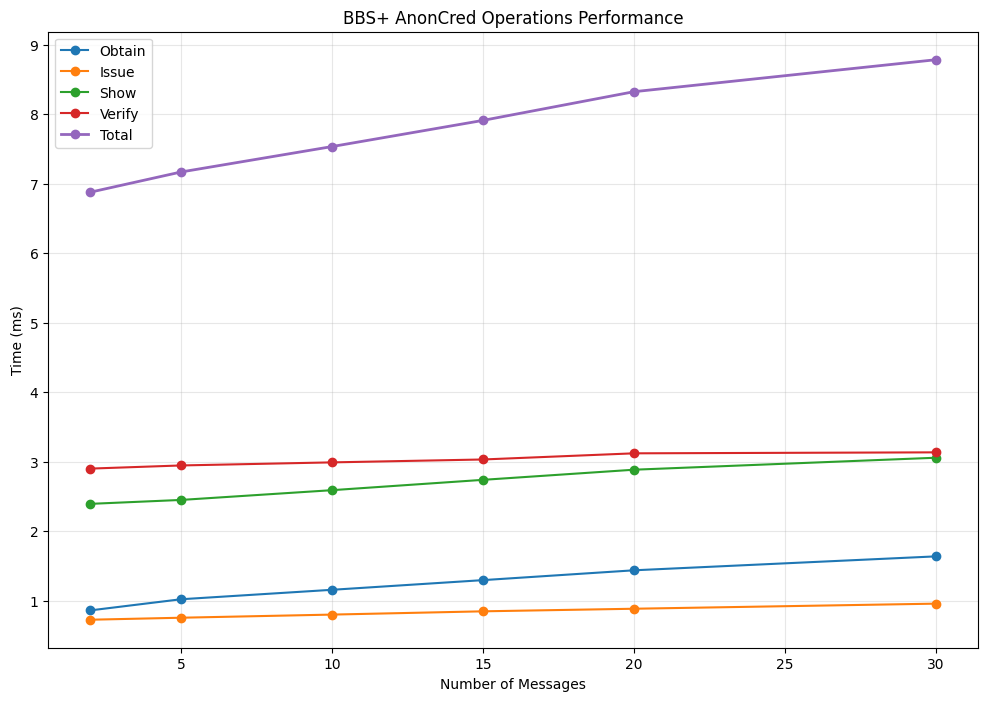

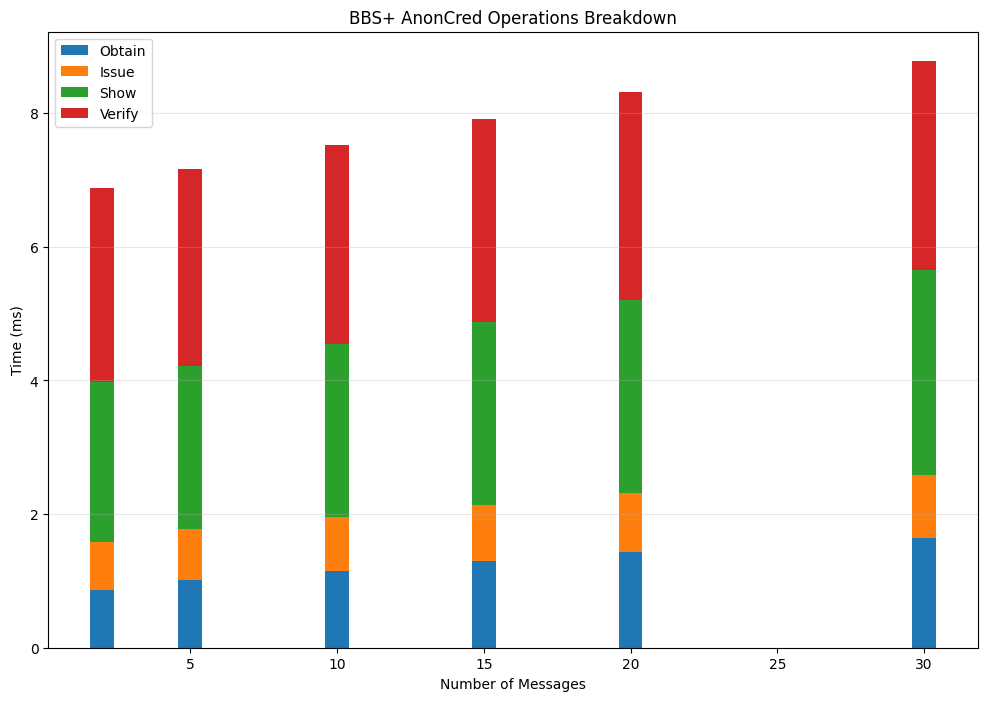

In [11]:
"""
Simple analyzer for BBS+ AnonCred benchmark results.
"""
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def analyze_benchmarks():
    """Analyze benchmark data for BBS+ AnonCred"""
    # Find the benchmark data directory
    base_path = Path("../target/criterion/bbs_plus_anoncreds")
    if not base_path.exists():
        print(f"Cannot find benchmark directory at {base_path}")
        return

    print(f"Loading data from {base_path}")

    # Dictionary to store results by message size
    results_by_msg_size = {}

    # Loop through all benchmark directories
    for bench_dir in base_path.iterdir():
        if not bench_dir.is_dir() or bench_dir.name == "report":
            continue

        try:
            # Parse the directory name to extract operation and message size
            # Format: bbs_plus_OPERATION_messages_SIZE
            parts = bench_dir.name.split('_')
            if len(parts) < 5:
                continue

            operation = parts[2]  # 'obtain', 'issue', 'show', or 'verify'
            msg_size = int(parts[4])  # The message size as a number

            # Find the estimates.json file
            estimates_file = bench_dir / "new" / "estimates.json"
            if not estimates_file.exists():
                continue

            # Load the benchmark data
            with open(estimates_file, 'r') as f:
                data = json.load(f)

            # Extract mean time in milliseconds
            mean_time = data["mean"]["point_estimate"] / 1_000_000
            std_dev = data["mean"]["standard_error"] / 1_000_000

            # Store the results
            if msg_size not in results_by_msg_size:
                results_by_msg_size[msg_size] = {}

            results_by_msg_size[msg_size][operation] = {
                "mean": mean_time,
                "std_dev": std_dev
            }

            print(f"Processed: {bench_dir.name} - {mean_time:.2f} ms")

        except Exception as e:
            print(f"Error processing {bench_dir.name}: {e}")

    if not results_by_msg_size:
        print("No valid benchmark data found!")
        return

    # Convert to a dataframe for easier analysis
    rows = []
    for msg_size, operations in results_by_msg_size.items():
        if len(operations) < 4:  # Skip if we don't have all operations
            continue

        row = {"Messages": msg_size}
        for op in ["obtain", "issue", "show", "verify"]:
            if op in operations:
                row[f"{op.capitalize()} Time (ms)"] = operations[op]["mean"]
                row[f"{op.capitalize()} Std Dev"] = operations[op]["std_dev"]

        # Calculate total time
        row["Total Time (ms)"] = sum(operations[op]["mean"]
                                     for op in operations)
        rows.append(row)

    if not rows:
        print("Could not create complete dataset from benchmark results!")
        return

    df = pd.DataFrame(rows)
    df = df.sort_values("Messages")

    # Save to CSV and JSON
    df.to_csv("bbs_plus_results.csv", index=False)
    print(f"\nSaved results to bbs_plus_results.csv")

    # Print summary
    print("\nBenchmark Summary:")
    print("-" * 80)
    print(df.to_string(index=False))

    # Create visualization
    create_plots(df)


def create_plots(df):
    """Create visualizations from the benchmark data"""
    # Scaling plot
    plt.figure(figsize=(12, 8))

    # Plot each operation
    plt.plot(df["Messages"], df["Obtain Time (ms)"], "o-", label="Obtain")
    plt.plot(df["Messages"], df["Issue Time (ms)"], "o-", label="Issue")
    plt.plot(df["Messages"], df["Show Time (ms)"], "o-", label="Show")
    plt.plot(df["Messages"], df["Verify Time (ms)"], "o-", label="Verify")
    plt.plot(df["Messages"], df["Total Time (ms)"],
             "o-", label="Total", linewidth=2)

    plt.xlabel("Number of Messages")
    plt.ylabel("Time (ms)")
    plt.title("BBS+ AnonCred Operations Performance")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save plot
    plt.savefig("bbs_plus_performance.png", dpi=300, bbox_inches="tight")
    print("Created visualization: bbs_plus_performance.png")

    # Create a stacked bar chart
    plt.figure(figsize=(12, 8))

    # Prepare data for stacked bars
    operations = ["Obtain", "Issue", "Show", "Verify"]
    bottoms = np.zeros(len(df))

    for operation in operations:
        values = df[f"{operation} Time (ms)"]
        plt.bar(df["Messages"], values, bottom=bottoms, label=operation)
        bottoms += values

    plt.xlabel("Number of Messages")
    plt.ylabel("Time (ms)")
    plt.title("BBS+ AnonCred Operations Breakdown")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)

    # Save stacked bar chart
    plt.savefig("bbs_plus_breakdown.png", dpi=300, bbox_inches="tight")
    print("Created visualization: bbs_plus_breakdown.png")


if __name__ == "__main__":
    analyze_benchmarks()